<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Traveling sales person

## Contents

In this notebook, we will learn

- How to parallelize the solution of the traveling sales person problem
- The concept of search overhead


## The traveling sales person (TSP) problem

Let us start by presenting the [traveling sales person (ASP) problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) and its solution using a [branch and bound algorithm](https://en.wikipedia.org/wiki/Branch_and_bound).

### Problem statement

- Given a graph $G$ with a distance table $C$ and an initial node (i.e. a city) in the graph
- Compute the shortest route that visits all cities exactly once, without returning to the initial city.


Note that there we consider a version of the problem in which do not return to the initial city. However, the classic version of the problem includes returning to the initial city.


As for the ASP problem we represent the distance table as a matrix, where $C_{ij}$ is the distance from node $i$ to node $j$. Next figure shows the input and solution (output) of the TSP problem for a simple 4-node graph. 

<div>
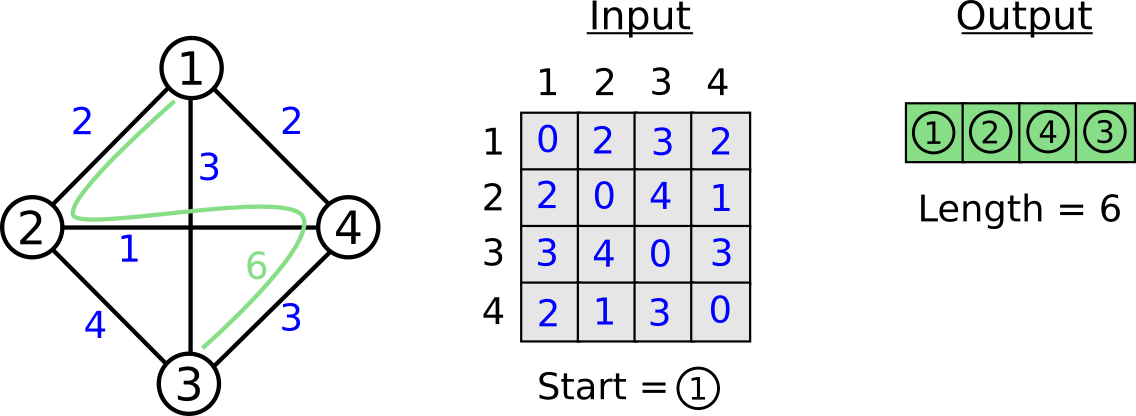
</div>

### Branch and bound algorithm

We consider a [branch and bound strategy](https://en.wikipedia.org/wiki/Branch_and_bound) to solve the ASP problem. The first ingredient of this strategy is to enumerate all potential solutions of the problem using a search tree. The tree is defined as follows:

- The root is the initial city
- The children of a node are the neighbor cities not visited so-far
- **We sort the children using the nearest city first heuristic**
- A node will be a leaf of the tree when all neighbor cities are already visited


The nearest city first heuristic is a way to speed up the search as we increase the possibility of finding the solution in the first paths enumerated in the tree.

<div>
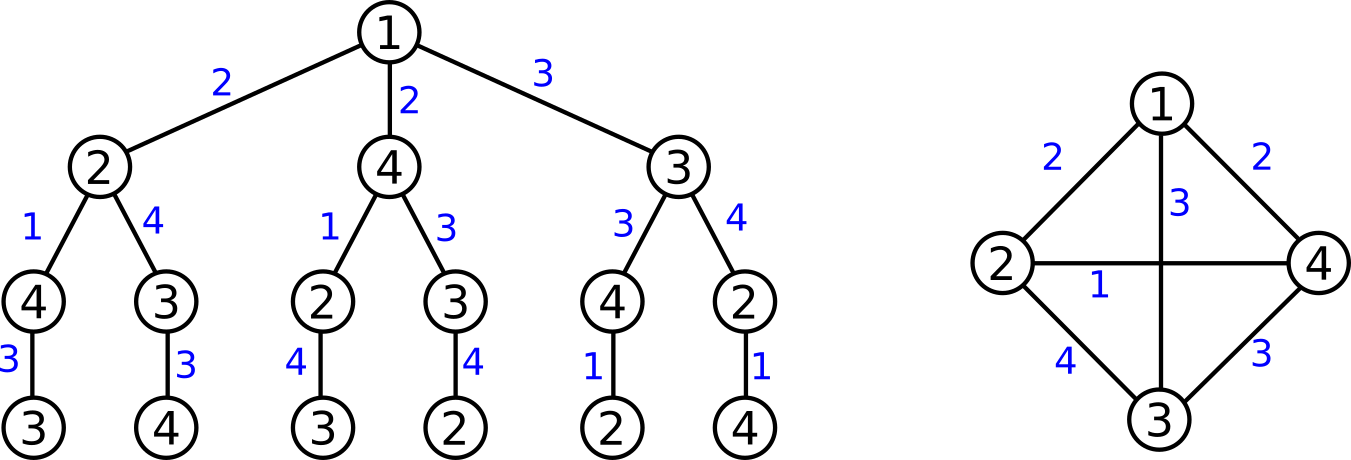
</div>

### Pruning the search tree

We look for a solution by going over the branches of the search tree via first-depth search. Each time we hit a lead in the tree we have a route between all cities and this a possible solution of the TSP problem (called a partial solution). In this process, we keep track of which is the shortest partial solution found so far. Note that we don't need to completely traverse all branches. In some cases, the distance at an intermediate point in a route will be already equal or greater than the best distance found so-far. In this case, we don't need to continue moving within this branch and we can jump to the next one. This is the "bound" criterion in our branch and bound strategy, which is also referred to as "pruning" the search tree.

In the example below, the first route has distance 6. At an intermediate point of the 2nd route we have already covered a distance equal to 6 which guarantees that the solution will not be in this part of the tree.


<div>
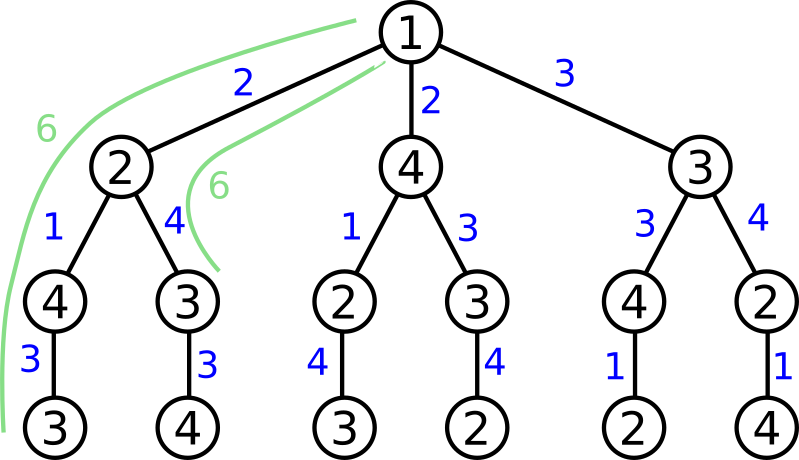
</div>

Thus, there are only 2 more complete routes that we need to visit. Using this strategy we have significantly reduced the routes visited: from 6 possible routes to 3 visited routes.

<div>
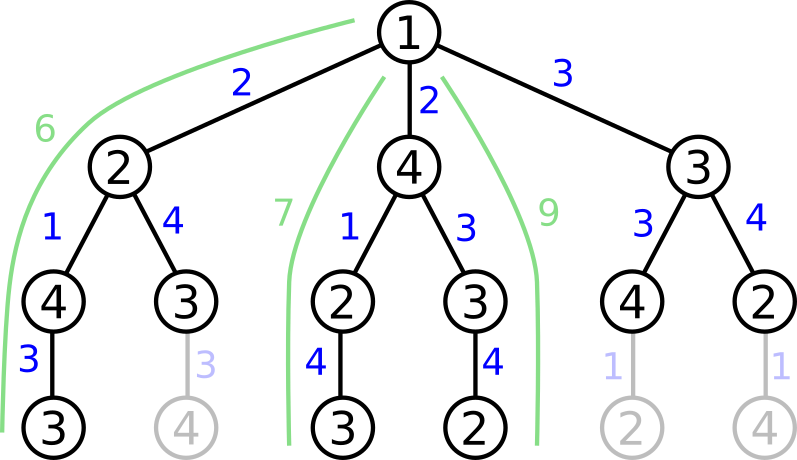
</div>

## Serial implementation

### Nearest-city first heuristic

In [2]:
function sort_neighbors(C)
    n = size(C,1)
    map(1:n) do i
        Ci = C[i,:]
        cities = sortperm(Ci)
        distances = Ci[cities]
        collect(zip(cities,distances))
    end
end

sort_neighbors (generic function with 1 method)

In [5]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]

4×4 Matrix{Int64}:
 0  2  3  2
 2  0  4  1
 3  4  0  3
 2  1  3  0

In [6]:
C_sorted = sort_neighbors(C)

4-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 0), (2, 2), (4, 2), (3, 3)]
 [(2, 0), (4, 1), (1, 2), (3, 4)]
 [(3, 0), (1, 3), (4, 3), (2, 4)]
 [(4, 0), (2, 1), (1, 2), (3, 3)]

In [7]:
city = 3
C_sorted[city]

4-element Vector{Tuple{Int64, Int64}}:
 (3, 0)
 (1, 3)
 (4, 3)
 (2, 4)

<div>
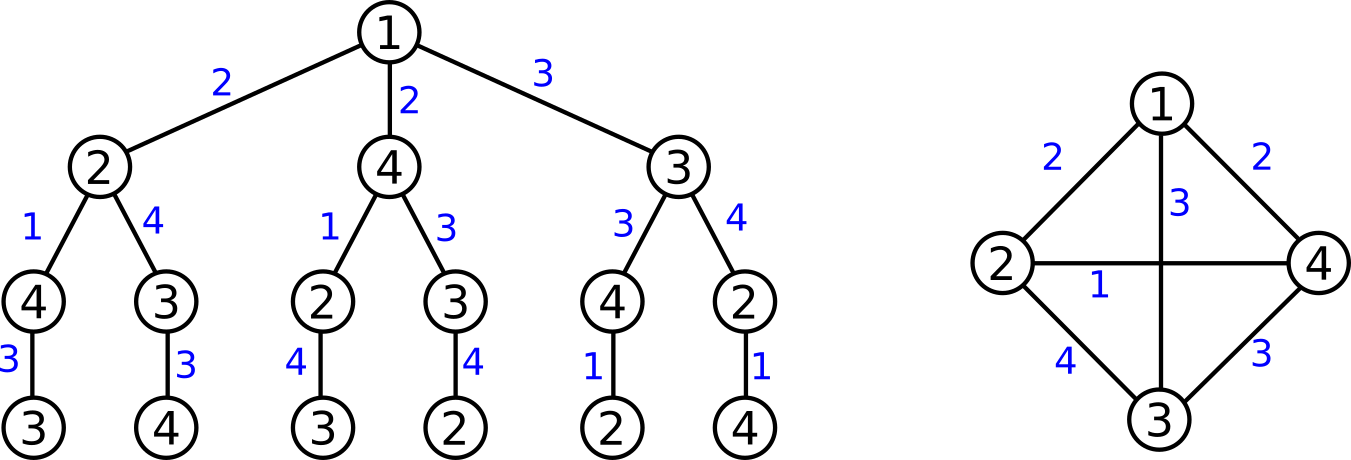
</div>

### Loop over all paths

In [8]:
function visital_all_paths(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    visital_all_paths_recursive!(C_sorted,hops,path)
end
function visital_all_paths_recursive!(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                visital_all_paths_recursive!(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        @show path
        return nothing
    end
end

visital_all_paths_recursive! (generic function with 1 method)

In [9]:
city = 1
visital_all_paths(C_sorted,city)

path = [1, 2, 4, 3]
path = [1, 2, 3, 4]
path = [1, 4, 2, 3]
path = [1, 4, 3, 2]
path = [1, 3, 4, 2]
path = [1, 3, 2, 4]


<div>
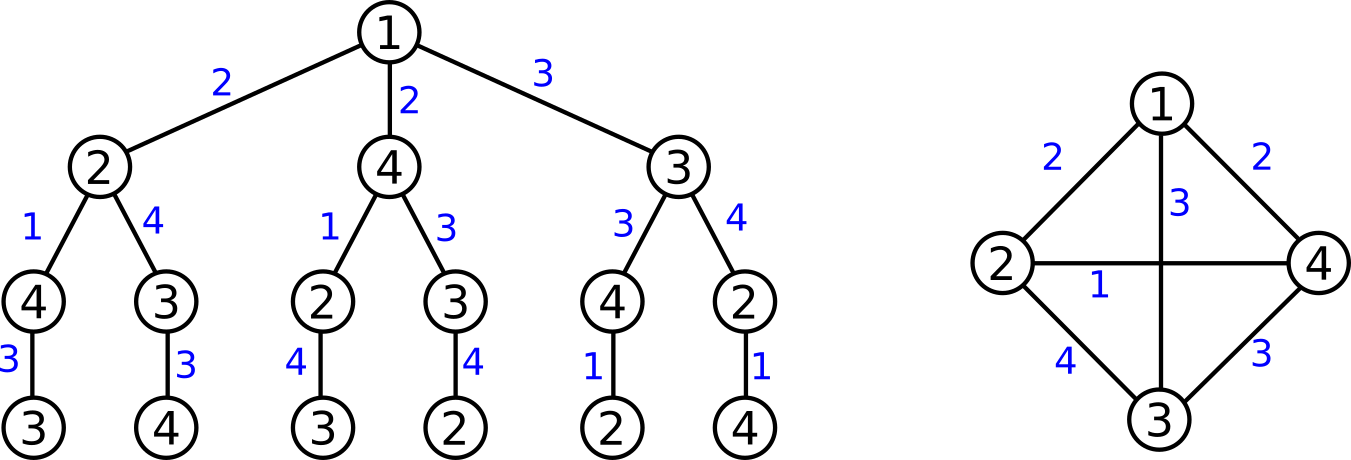
</div>

### Serial implementation without pruning

In [10]:
function tsp_serial_no_prune(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_no_prune_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = min(distance,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

tsp_serial_no_prune_recursive! (generic function with 1 method)

In [11]:
city = 1
min_distance = tsp_serial_no_prune(C_sorted,city)

6

### Final serial implementation

In [13]:
function tsp_serial(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
    if distance >= min_distance
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = min(distance,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

tsp_serial_recursive! (generic function with 1 method)

In [14]:
city = 1
min_distance = tsp_serial(C_sorted,city)

6

### Performance

In [33]:
n = 11
using Random
Random.seed!(1)
C = rand(1:10,n,n)
C_sorted = sort_neighbors(C)
city = 1
@time tsp_serial_no_prune(C_sorted,city)
@time tsp_serial(C_sorted,city)

  1.286362 seconds (1 allocation: 144 bytes)
  0.002820 seconds (1 allocation: 144 bytes)


22

## Parallel implementation

In [34]:
using Distributed

In [35]:
if workers() == procs()
    addprocs(3)
end

3-element Vector{Int64}:
 2
 3
 4

In [36]:
function enumerate_paths_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[]))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    end
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
    for w in workers()
        put!(jobs_chnl,(0,Int[]))
    end
    close(jobs_chnl)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    if hops == max_hops
        @show path
        put!(jobs_chnl,(hops,copy(path)))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(C_sorted,next_hops,path,max_hops,jobs_chnl)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl)
    while true
        hops,path = take!(jobs_chnl)
        if hops == 0
            println("Done!")
            break
        end
        consume_jobs_recursive(C_sorted,hops,path)
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                consume_jobs_recursive(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        @show path
        return nothing
    end
end

In [40]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]
C_sorted = sort_neighbors(C)
city = 1
max_hops = 2
min_distance = enumerate_paths_dist(C_sorted,city,max_hops)

path = [1, 2, 0, 0]
path = [1, 4, 0, 0]
path = [1, 3, 0, 0]
      From worker 2:	path = [1, 2, 4, 3]
      From worker 4:	path = [1, 3, 4, 2]
      From worker 3:	path = [1, 4, 2, 3]
      From worker 3:	path = [1, 4, 3, 2]
      From worker 2:	path = [1, 2, 3, 4]
      From worker 4:	path = [1, 3, 2, 4]
      From worker 2:	Done!
      From worker 4:	Done!
      From worker 3:	Done!


### How to track the global minimum distance?

In [42]:
buffer = 1 # very important
min_distance_chnl = RemoteChannel(()->Channel{Int}(buffer))
put!(min_distance_chnl,typemax(Int))
@sync for w in workers()
    @spawnat w begin
         sleep(rand(1:3))
         min_distance = take!(min_distance_chnl)
         @show min_distance
         distance = rand(5:10)
         min_distance = min(distance,min_distance)
         @show distance
         put!(min_distance_chnl,min_distance)
    end
end
min_distance = take!(min_distance_chnl)
@show min_distance
close(min_distance_chnl)

      From worker 3:	min_distance = 9223372036854775807
      From worker 3:	distance = 9
      From worker 4:	min_distance = 9
      From worker 4:	distance = 6
      From worker 2:	min_distance = 6
      From worker 2:	distance = 6
min_distance = 6


### Final parallel implementation

In [44]:
function tsp_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[],0))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    min_distance_chnl = RemoteChannel(()->Channel{Int}(1))
    put!(min_distance_chnl,typemax(Int))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    end
    min_distance = take!(min_distance_chnl)
    close(min_distance_chnl)
    return min_distance
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance = 0
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
    for w in workers()
        put!(jobs_chnl,(0,Int[],0))
    end
    close(jobs_chnl)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
    num_cities = length(C_sorted)
    if hops == max_hops
        @show path, distance
        put!(jobs_chnl,(hops,copy(path),distance))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(
                        C_sorted,next_hops,path,max_hops,jobs_chnl,next_distance)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
    while true
        hops,path,distance = take!(jobs_chnl)
        if hops == 0
            println("Done!")
            break
        end
        min_distance = take!(min_distance_chnl)
        put!(min_distance_chnl,min_distance)
        consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
    if distance >= min_distance
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                min_distance = consume_jobs_recursive(
                        C_sorted,next_hops,path,min_distance_chnl,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = take!(min_distance_chnl)
        min_distance = min(min_distance,distance)
        put!(min_distance_chnl,min_distance)
        @show path, distance, min_distance
        return min_distance
    end
end

In [50]:
city = 1
max_hops = 2
min_distance = tsp_dist(C_sorted,city,max_hops)

(path, distance) = ([1, 2, 0, 0], 2)
(path, distance) = ([1, 4, 0, 0], 2)
(path, distance) = ([1, 3, 0, 0], 3)
      From worker 3:	(path, distance, min_distance) = ([1, 3, 4, 2], 7, 7)
      From worker 2:	(path, distance, min_distance) = ([1, 2, 4, 3], 6, 6)
      From worker 3:	Done!
      From worker 4:	(path, distance, min_distance) = ([1, 4, 2, 3], 7, 6)
      From worker 2:	Done!
      From worker 4:	Done!


6